# Symlink patches

In [7]:
import os
import tqdm
import shutil
from pathlib import Path

In [ ]:
os.chdir('/data/pathology/projects/ais-cap/code/git/clemsgrs/hipt')

In [2]:
root_dir = Path('/data/pathology/projects/ais-cap/code/git/clemsgrs/hs2p')

In [3]:
dataset_name = 'tcga_brca'
patch_dir = Path(root_dir, 'output', dataset_name, 'patches')

In [12]:
output_dir = Path(f'data/{dataset_name}/patches')
try:
    output_dir.mkdir(parents=True)
except:
    shutil.rmtree(output_dir)
    output_dir.mkdir(parents=True)

In [13]:
patch_size = 4096
fmt = 'jpg'

In [16]:
# with open(Path(root_dir, f'data/{dataset_name}/slide_list.txt'), 'r') as f:
with open(f'data/{dataset_name}/toy_list.txt', 'r') as f:
    slide_ids = sorted([Path(s.strip()).stem for s in f.readlines()])
    with tqdm.tqdm(
        slide_ids,
        desc=(f'Generating Symlinks'),
        unit=' slide',
        ncols=100,
    ) as t:      
        for s in t:
            src_dir = Path(patch_dir, s, str(patch_size), fmt)
            dst_dir = Path(output_dir, s, str(patch_size), fmt)
            dst_dir.mkdir(exist_ok=True, parents=True)
            patches = [p.name for p in src.glob(f'*.{fmt}')]
            for patch in patches:
                src = Path(src_dir, patch)
                dst = Path(dst_dir, patch)
                dst.symlink_to(src)
                t.update(1/len(patches)/len(slide_ids))

Generating Symlinks: 100%|████████████████████████████████████████| 1/1 [00:04<00:00,  4.12s/ slide]


### Get average number of patches per slide

In [17]:
import numpy as np
import pandas as pd
from collections import defaultdict

In [18]:
slide_patches = [s for s in patch_dir.iterdir()]
len(slide_patches)

93

In [19]:
data = defaultdict(list)
for d in slide_patches:
    slide_dir = Path(d, str(patch_size), fmt)
    m = len(list(slide_dir.glob(f'*.{fmt}')))
    data['slide_id'].append(d.name)
    data['M'].append(m)

In [20]:
M_df = pd.DataFrame.from_dict(data)
M_df.head()

,slide_id,M
0,TCGA-A2-A0YK-01Z-00-DX1.FB23FC30-B3B2-452A-A6B...,196
1,TCGA-A2-A0EW-01Z-00-DX1.F24495CB-63D8-483F-983...,135
2,TCGA-A2-A0SU-01Z-00-DX1.22420EE2-4FEB-42F3-954...,279
3,TCGA-A2-A0CW-01Z-00-DX1.8E313A22-B0E8-44CF-ADE...,167
4,TCGA-A2-A0T0-01Z-00-DX1.51F904DA-A4B5-4451-8AE...,205


In [21]:
M_df.M.mean()

208.16129032258064

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [23]:
nslide = defaultdict(list)
dfs = []
nfold = 10
for i in range(nfold):
    fold_dir = Path(f'data/{dataset_name}/splits/fold_{i}')
    for partition in ['train', 'tune', 'test']:
        df = pd.read_csv(Path(fold_dir, f'{partition}.csv'))
        nslide[partition].append(len(df))
        df = M_df.merge(df, how='inner', on='slide_id')
        M = df.M.mean()
        tmp = pd.DataFrame.from_dict({'avg_M': [M], 'partition': [partition]})
        dfs.append(tmp)
        
df = pd.concat(dfs)
df.head()

,avg_M,partition
0,214.800000,train
0,181.750000,tune
0,179.500000,test
0,200.275362,train
0,227.538462,tune


In [24]:
avg_nslide = [np.mean(nslide[p]) for p in ['train', 'tune', 'test']]
avg_nslide

[712.9, 79.9, 82.2]

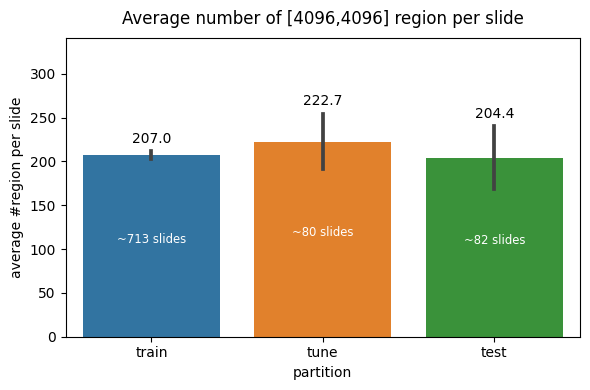

In [26]:
pad = 10
save = False

plt.figure(dpi=100)
ax = sns.barplot(data=df, y='avg_M', x='partition', errorbar='sd')
for i, p in enumerate(ax.patches):
    errbar = ax.lines[i].get_data()[1]
    std = errbar[1] - errbar[0]
    
    x, y = p.get_x(), p.get_y()
    w, h = p.get_width(), p.get_height()
    txt_x, txt_y = x+w/2, h+std/2+pad
    
    plt.text(txt_x, txt_y, f'{h:.1f}', horizontalalignment='center')
    
    n = avg_nslide[i]
    plt.text(x+w/2, h/2, f'~{n:.0f} slides', horizontalalignment='center', verticalalignment='bottom', fontsize='small', color='white')

plt.xlabel('partition')
plt.ylabel('average #region per slide')
plt.ylim(0,df.avg_M.max()*1.2)
plt.title(f'Average number of [4096,4096] region per slide', pad=10)
plt.tight_layout()
if save:
    plt.savefig('average_sample_count.png', dpi=300)
plt.show()

### Breakdown per subtype

In [27]:
nslide = {'train': defaultdict(list), 'tune': defaultdict(list), 'test': defaultdict(list)}
dfs = []
nfold = 10
for i in range(nfold):
    fold_dir = Path(f'data/{dataset_name}/splits/fold_{i}')
    for partition in ['train', 'tune', 'test']:
        df = pd.read_csv(Path(fold_dir, f'{partition}.csv'))
        df['subtype'] = df['label'].apply(lambda x: 'IDC' if x == 0 else 'ILC')
        for subtype, gdf in df.groupby('subtype'):
            nslide[partition][subtype].append(len(gdf))
            gdf = M_df.merge(gdf, how='inner', on='slide_id')
            M = gdf.M.mean()
            tmp = pd.DataFrame.from_dict({'avg_M': [M], 'partition': [partition], 'subtype': [subtype]})
            dfs.append(tmp)
        
df = pd.concat(dfs)
df.head()

,avg_M,partition,subtype
0,209.190476,train,IDC
0,244.250000,train,ILC
0,197.142857,tune,IDC
0,74.000000,tune,ILC
0,171.500000,test,IDC


In [28]:
nslide

{'train': defaultdict(list,
             {'IDC': [597, 587, 598, 588, 595, 595, 589, 595, 588, 589],
              'ILC': [118, 124, 120, 120, 121, 121, 123, 120, 121, 120]}),
 'tune': defaultdict(list,
             {'IDC': [64, 71, 65, 67, 68, 65, 68, 61, 69, 66],
              'ILC': [15, 13, 15, 14, 12, 12, 13, 14, 13, 14]}),
 'test': defaultdict(list,
             {'IDC': [65, 68, 63, 71, 63, 66, 69, 70, 69, 71],
              'ILC': [16, 12, 14, 15, 16, 16, 13, 15, 15, 15]})}

In [29]:
avg_nslide = [np.mean(nslide[p][s]) for s in df.subtype.unique() for p in ['train', 'tune', 'test']]
avg_nslide

[592.1, 66.4, 67.5, 120.8, 13.5, 14.7]

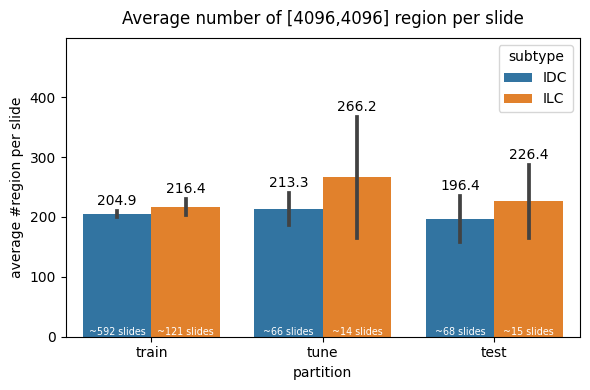

In [32]:
pad = 10
save = False

plt.figure(dpi=100)
ax = sns.barplot(data=df, y='avg_M', hue='subtype', x='partition', errorbar='sd')
for i, p in enumerate(ax.patches):
    errbar = ax.lines[i].get_data()[1]
    std = errbar[1] - errbar[0]
    
    x, y = p.get_x(), p.get_y()
    w, h = p.get_width(), p.get_height()
    txt_x, txt_y = x+w/2, h+std/2+pad
    
    plt.text(txt_x, txt_y, f'{h:.1f}', horizontalalignment='center')
    
    n = avg_nslide[i]
    plt.text(x+w/2, 0, f'~{n:.0f} slides', horizontalalignment='center', verticalalignment='bottom', fontsize='x-small', color='white')

plt.xlabel('partition')
plt.ylabel('average #region per slide')
plt.ylim(0,499)
plt.title(f'Average number of [4096,4096] region per slide', pad=10)
plt.tight_layout()
if save:
    plt.savefig('average_sample_count.png', dpi=300)
plt.show()